# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__ *liste des points auxquels on cherche à répondre*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta')
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta')

In [3]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','RESPID','UCPSID','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
education = ['CCHGSC','CSUEXP','CATTSC','CSKIPSC','CGETBY','CHMWK','CINTSC','CWRKSC','UENG','UENGNEG','UENGPOS']
family = ['GHMAD','GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT']
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','GHEADS','KAPPMED','SSHELP']
programs_hh = ['MPUBHOUS']

In [4]:
# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh + programs_hh]


In [5]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,KAPPMED,SSHELP,SCRNRSLT,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,MPUBHOUS
0,5561612801,Focal child 1 (age 0-5),5561612803,5561612800,F,3,15,WI,2,A1,...,Inapplicable,Inapplicable,CC,2,0,3,1,4,Owned by someone in household,Inapplicable
1,5470400001,Focal child 2 (age 6-17),5470400003,5470400000,M,14,15,WI,2,A1,...,Yes,Inapplicable,CC,0,2,3,2,2,Rented for cash,Inapplicable
2,5787427204,Focal child 2 (age 6-17),5787427205,5787427200,F,9,15,WI,2,A1,...,Inapplicable,Inapplicable,CC,0,4,6,1,3,Rented for cash,No
3,5410681601,Focal child 1 (age 0-5),5410681604,5410681600,M,4,15,WI,2,A1,...,Inapplicable,Inapplicable,CC,3,0,5,1,2,Rented for cash,No
4,5051721601,Focal child 2 (age 6-17),5051721605,5051721600,F,17,15,WI,2,A1,...,Inapplicable,Inapplicable,CC,0,4,5,1,4,Rented for cash,Yes


In [37]:
# Divide child data in three dfs

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin(['Focal child 1 (age 0-5)','Focal child 2 (age 6-17)'])]

# FC1 : focal child, aged 0-5
fc1 = child[child['PERSTYPE']=='Focal child 1 (age 0-5)']

# FC2 : focal child, aged 6-11
fc2 = child[(child['PERSTYPE']=='Focal child 2 (age 6-17)') & (child['UAGE'] < 12)]

# FC3 : focal child, aged 12-17
fc3 = child[(child['PERSTYPE']=='Focal child 2 (age 6-17)') & (child['UAGE'] >= 12)]

In [38]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}')

Shapes of dataframes:
fc1: (12268, 62)
fc2: (10925, 62)
fc3:(11087, 62)


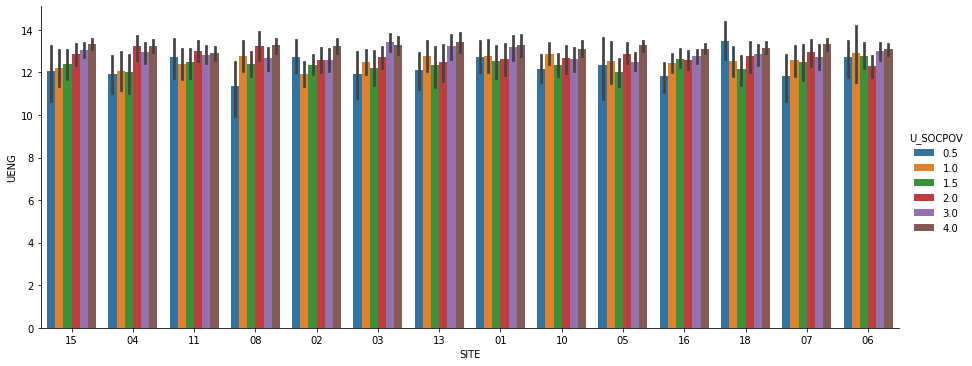

In [18]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc2, height=5, aspect=2.5)


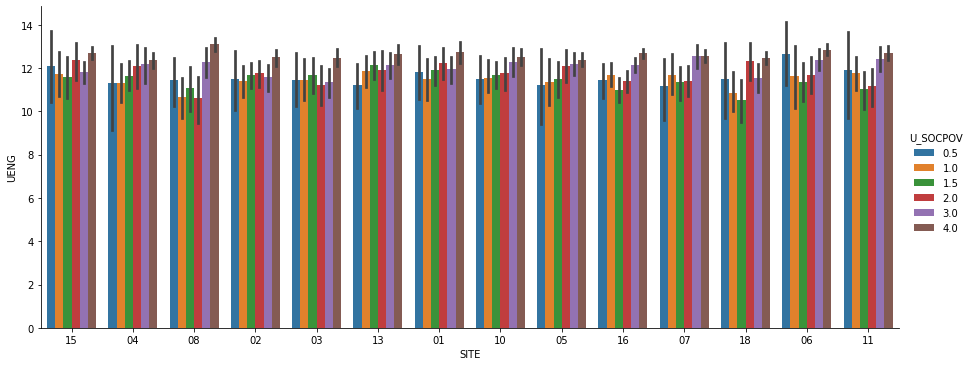

In [19]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc3, height=5, aspect=2.5)

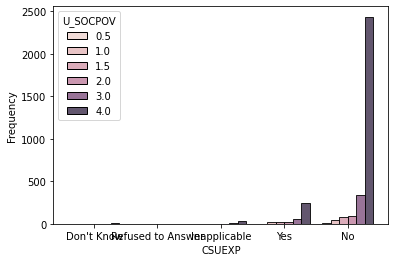

In [55]:
sns.histplot(x='CSUEXP', hue='U_SOCPOV', multiple='dodge', shrink=.8, stat='frequency', data=fc3)

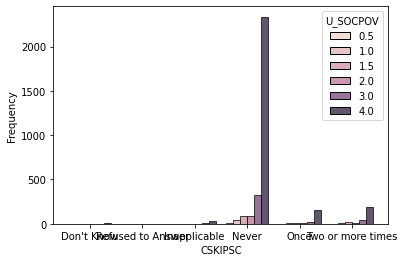

In [56]:
sns.histplot(x='CSKIPSC', hue='U_SOCPOV', multiple='dodge', shrink=.8, stat='frequency', data=fc3)